In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.interpolate import pchip_interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps

In [2]:
# Path to the dataset
base_path = Path("Processed_data/") # Path to the dataset

path_save_S1 = base_path /"Stage_1"
path_save_S2 = base_path /"Stage_2"

path_trajectory_S1 = path_save_S1 / "Trajectory_Ah_throughput"
path_trajectory_S2 = path_save_S2 / "Trajectory_Ah_throughput"

path_QV_S1 = path_save_S1 / "Interpolated_QV_curve"
path_QV_S2 = path_save_S2 / "Interpolated_QV_curve"

path_dQdV_S1 = path_save_S1 / "Interpolated_dQdV_curve"
path_dQdV_S2 = path_save_S2 / "Interpolated_dQdV_curve"

valid_cells_S1 = np.loadtxt(path_save_S1 / "valid_cells_95.txt",dtype=str).flatten().tolist()
valid_cells_S2 = np.loadtxt(path_save_S2 / "valid_cells_95.txt",dtype=str).flatten().tolist()

# Load metadata
meta_data = pd.read_csv(base_path / "experiments_meta.csv")

meta_data_S1 = meta_data[meta_data["stage"]==1]
meta_data_S2 = meta_data[meta_data["stage"]==2]


In [3]:
meta_data.columns

Index(['serial_internal', 'serial', 'lab', 'type', 'tp', 'cell', 'amb_temp_tp',
       'soc_max_tp', 'dod_tp', 'c_ch_tp', 'c_dch_tp', 'sampling', 'stage',
       'm_0', 'scale', 'R_1khz_0', 'resistance_meter', 'U_0', ' volt_meter'],
      dtype='object')

# Interpolate the trajectories to equidistant SOH

In [80]:
def find_non_sorted_elements(arr):
    """
    Identifies the indices of non-sorted elements in a numpy array.

    Parameters:
        arr (numpy.ndarray): The input array of numbers.

    Returns:
        list: A list of indices of elements that are out of order.
    """
    if len(arr) < 2:
        return []  # An array with 0 or 1 elements is always sorted

    non_sorted_indices = []

    for i in range(1, len(arr) - 1):
        if not (arr[i - 1] <= arr[i] <= arr[i + 1] or arr[i - 1] >= arr[i] >= arr[i + 1]):
            non_sorted_indices.append(i)

    # Refined boundary checks
    if len(arr) > 1:
        if not (arr[0] <= arr[1] or arr[0] >= arr[1]):
            non_sorted_indices.insert(0, 0)
        if not (arr[-1] <= arr[-2] or arr[-1] >= arr[-2]):
            non_sorted_indices.append(len(arr) - 1)

    return non_sorted_indices

C:\Users\til22008\AppData\Local\Temp\ipykernel_11348\3032795898.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_interp_S1 = pd.concat([data_interp_S1,pd.DataFrame({'CellID':cell,'Index':iii,'Ah-throughput':y_interp[::-1],'Q':x_interp[::-1]})],ignore_index=True)
C:\Users\til22008\AppData\Local\Temp\ipykernel_11348\3032795898.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_interp_S2 = pd.concat([data_interp_S2,pd.DataFrame({'CellID':cell,'Index':iii,'Ah-throughput':y_interp[::-

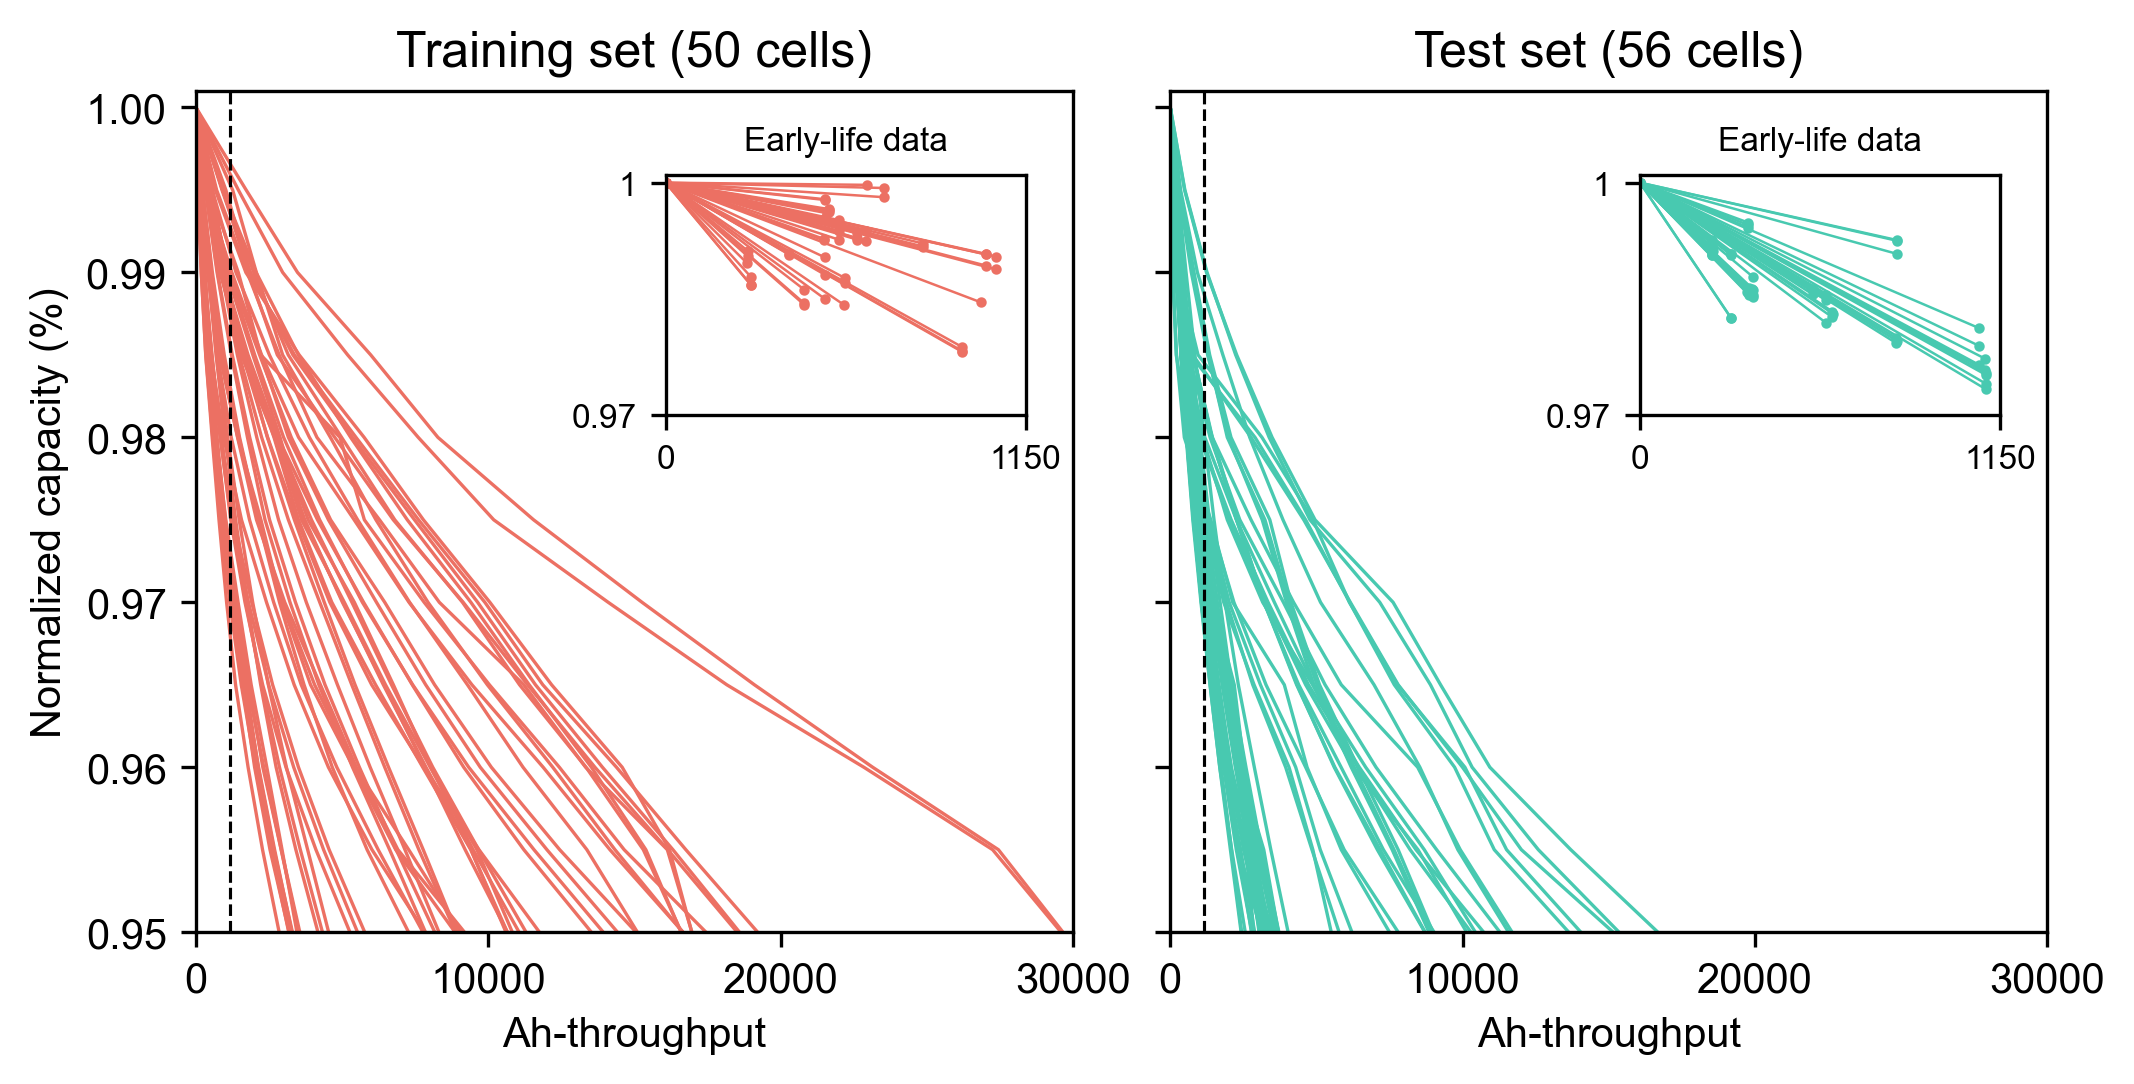

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

markersize_ = 1.5
linewidth_ = 0.8
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5),dpi=300,sharex=True,sharey=True,constrained_layout=True)
inset_ax_1 = inset_axes(ax[0], width=1.2, height=0.8, loc='upper right',bbox_to_anchor=(.97, 0.925), bbox_transform=ax[0].transAxes)
inset_ax_2 = inset_axes(ax[1], width=1.2, height=0.8, loc='upper right',bbox_to_anchor=(.97, 0.925), bbox_transform=ax[1].transAxes)

interp_step = 0.005
data_interp_S1 = pd.DataFrame(columns=['CellID','Index','Ah-throughput','Q'])
for iii,cell in enumerate(valid_cells_S1):
    data = pd.read_csv(path_trajectory_S1 / f"{cell}.csv")
    # 0 is Ahthroughput, 1 is capacity, 2 is normalized capacity
    # interpolate to obtain the same number of points based on equidistant SOH
    x_raw = data["2"].values
    y_raw = data["0"].values
    non_sort_idx = find_non_sorted_elements(x_raw)
    x_raw_sort = np.delete(x_raw,non_sort_idx)
    y_raw_sort = np.delete(y_raw,non_sort_idx)

    sort_idx = np.argsort(x_raw_sort)
    x_raw_sort = x_raw_sort[sort_idx]
    y_raw_sort = y_raw_sort[sort_idx]
    # Use pchip interpolation to interpolate the data
    x_interp = np.arange(0.95,1,interp_step)
    y_interp = np.abs(pchip_interpolate(x_raw_sort,y_raw_sort,x_interp))
    data_interp_S1 = pd.concat([data_interp_S1,pd.DataFrame({'CellID':cell,'Index':iii,'Ah-throughput':y_interp[::-1],'Q':x_interp[::-1]})],ignore_index=True)

    ax[0].plot(y_interp,x_interp,'-',color = '#ec7063',linewidth=linewidth_)
    inset_ax_1.plot(y_raw[:2],x_raw[:2],'o-',color = '#ec7063',markersize=markersize_,linewidth=linewidth_-0.2)
    
    
data_interp_S2 = pd.DataFrame(columns=['CellID','Index','Ah-throughput','Q'])
for iii,cell in enumerate(valid_cells_S2):
    data = pd.read_csv(path_trajectory_S2 / f"{cell}.csv")
    # 0 is Ahthroughput, 1 is capacity, 2 is normalized capacity
    # interpolate to obtain the same number of points based on equidistant SOH
    x_raw = data["2"].values
    y_raw = data["0"].values
    non_sort_idx = find_non_sorted_elements(x_raw)
    x_raw_sort = np.delete(x_raw,non_sort_idx)
    y_raw_sort = np.delete(y_raw,non_sort_idx)

    sort_idx = np.argsort(x_raw_sort)
    x_raw_sort = x_raw_sort[sort_idx]
    y_raw_sort = y_raw_sort[sort_idx]
    # Use pchip interpolation to interpolate the data
    x_interp = np.arange(0.95,1,interp_step)
    y_interp = np.abs(pchip_interpolate(x_raw_sort,y_raw_sort,x_interp))
    data_interp_S2 = pd.concat([data_interp_S2,pd.DataFrame({'CellID':cell,'Index':iii,'Ah-throughput':y_interp[::-1],'Q':x_interp[::-1]})],ignore_index=True)  

    ax[1].plot(y_interp,x_interp,'-',color = '#48c9b0',linewidth=linewidth_)
    inset_ax_2.plot(y_raw[:2],x_raw[:2],'o-',color = '#48c9b0',markersize=markersize_,linewidth=linewidth_-0.2)  


ax[0].set_xlabel("Ah-throughput")
ax[0].set_ylabel("Normalized capacity (%)")
ax[0].set_title("Training set (50 cells)")
ax[0].set_ylim(0.95,1.001)
ax[0].set_xlim(0,30000)
ax[0].set_xticks([0,10000,20000,30000])

ax[0].vlines(1150,0.95,1.001,linestyles='dashed',linewidth=0.75,color='black')
ax[1].vlines(1150,0.95,1.001,linestyles='dashed',linewidth=0.75,color='black')


ax[1].set_xlabel("Ah-throughput")
# ax[1].set_ylabel("Normalized capacity")
ax[1].set_title("Test set (56 cells)")

inset_ax_1.set_xlim(0,1150)
inset_ax_1.set_ylim(0.97,1.001)
inset_ax_1.set_xticks([0,1150])
inset_ax_1.set_yticks([0.97,1])
inset_ax_1.set_xticklabels([0,1150],fontsize=8)
inset_ax_1.set_yticklabels([0.97,1],fontsize=8)
inset_ax_1.set_title("Early-life data",fontsize=8)

inset_ax_2.set_xlim(0,1150)
inset_ax_2.set_ylim(0.97,1.001)
inset_ax_2.set_xticks([0,1150])
inset_ax_2.set_yticks([0.97,1.00])
inset_ax_2.set_xticklabels([0,1150],fontsize=8)
inset_ax_2.set_yticklabels([0.97,1],fontsize=8)

inset_ax_2.set_title("Early-life data",fontsize=8)
# plt.tight_layout()
plt.show()

data_interp_S1.to_csv("trajectory_Ah_throughput_interp_train.csv",index=False)
data_interp_S2.to_csv("trajectory_Ah_throughput_interp_test.csv",index=False)

# Visualize QV curve and dQdV curves

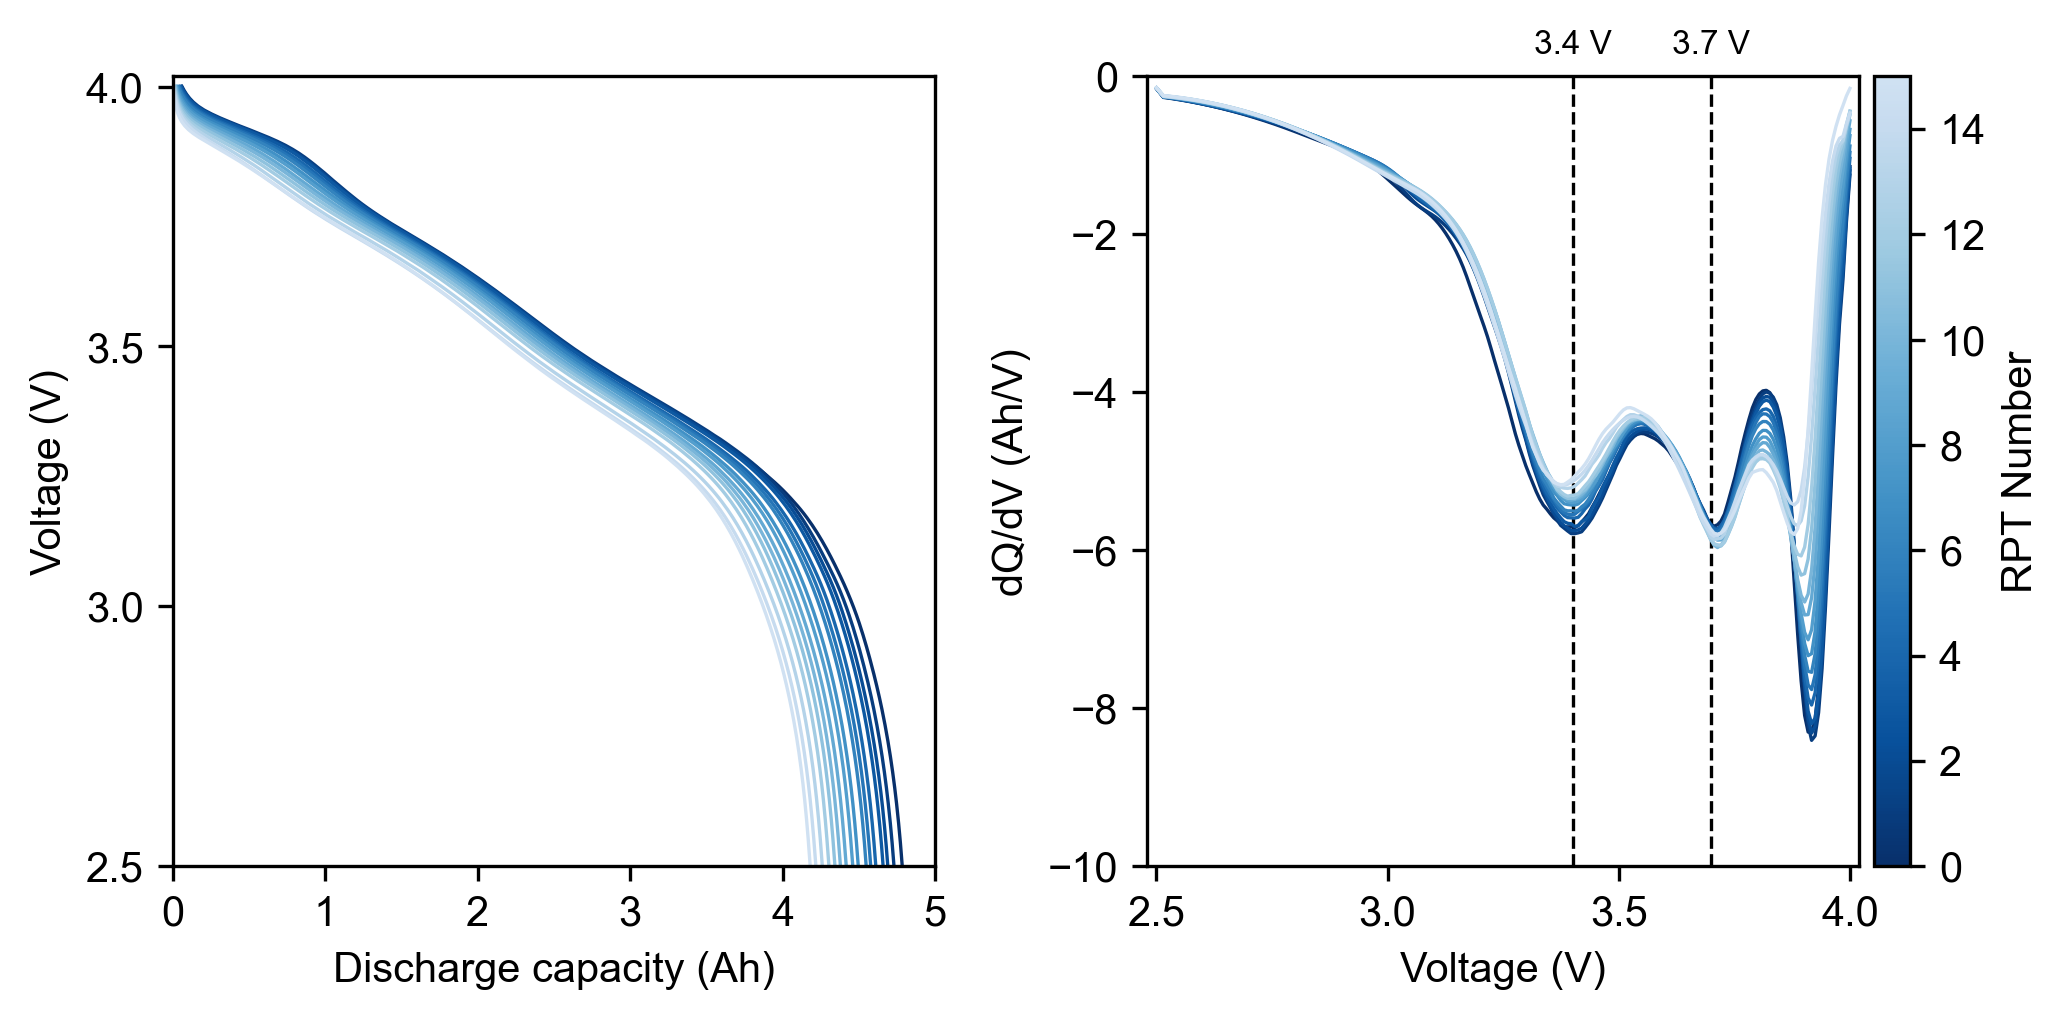

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

cell = 'TP_z17_01'
QV_data = pd.read_csv(path_QV_S1 / f"{cell}.csv").T.abs().to_numpy()
dQdV_data = pd.read_csv(path_dQdV_S1 / f"{cell}.csv").T.to_numpy()
V = np.linspace(2.5, 4, 200)

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), dpi=300)

# Get the reversed "Blues" colormap and trim its range
original_cmap = colormaps["Blues_r"]
trimmed_cmap = LinearSegmentedColormap.from_list(
    "Blues_r_trimmed", original_cmap(np.linspace(0, 0.8, 256))
)

# Normalize the indices to map them to the colormap range (0, 1)
num_curves = QV_data.shape[0]
norm = Normalize(vmin=0, vmax=num_curves - 1)  # Normalize indices to match colorbar
norm_indices = np.linspace(0, 1, num_curves)

for iii in range(num_curves):
    color = trimmed_cmap(norm(iii))  # Use the trimmed colormap
    ax[0].plot(QV_data[iii], V, '-', color=color, linewidth=linewidth_)
    ax[1].plot(V, dQdV_data[iii], '-', color=color, linewidth=linewidth_)

# Add vertical lines
x1, x2 = 3.4, 3.7
ax[1].vlines(x=x1, ymin=-10, ymax=0, color='k', linestyle='--', linewidth=linewidth_, zorder=-10)
ax[1].vlines(x=x2, ymin=-10, ymax=0, color='k', linestyle='--', linewidth=linewidth_, zorder=-10)

# Add text labels above the vertical lines
ax[1].text(x1, 0.2, f"{x1:.1f} V", color='k', fontsize=8, ha='center', va='bottom')
ax[1].text(x2, 0.2, f"{x2:.1f} V", color='k', fontsize=8, ha='center', va='bottom')

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=trimmed_cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

# Add the colorbar overlapping the right subplot
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('RPT Number', fontsize=10)

ax[0].set_xlabel("Discharge capacity (Ah)")
ax[0].set_ylabel("Voltage (V)")
# ax[0].set_title("Q-V curves")
ax[0].set_xlim(0, 5)
ax[0].set_ylim(2.5, 4.02)
ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[0].set_yticks([2.5, 3, 3.5, 4])

ax[1].set_xlabel("Voltage (V)")
ax[1].set_ylabel("dQ/dV (Ah/V)")
# ax[1].set_title("dQ/dV curves")
ax[1].set_xlim(2.48, 4.02)
ax[1].set_ylim(-10, 0)

plt.tight_layout()
plt.show()


# Extract features and outputs

In [85]:
# Functions to extract curve difference features
def extract_curve_diff_features(QV_data, dQdV_data, V, V1=3.4, V2=3.7,start_idx=0,end_idx=1):
    """
    Extracts curve difference features from Q-V and dQ/dV curves.

    Parameters:
        QV_data (numpy.ndarray): A 2D array containing Q-V curves.
        dQdV_data (numpy.ndarray): A 2D array containing dQ/dV curves.
        V (numpy.ndarray): The voltage array corresponding to the curves.
        V1 (float): The first voltage threshold for feature extraction.
        V2 (float): The second voltage threshold for feature extraction.

    Returns:
        numpy.ndarray: A 2D array containing the extracted features.
    """
    num_features = 5 # Two delta Q features and three dQ/dV features
    features = np.zeros((1, num_features))

    # Extract features from Q-V curves
    
    QV_curve_start = QV_data[start_idx]
    QV_curve_end = QV_data[end_idx]
    dQdV_curve_start = dQdV_data[start_idx]
    dQdV_curve_end = dQdV_data[end_idx]

    # Find the indices corresponding to the voltage thresholds
    idx1 = np.argmin(np.abs(V - V1))
    idx2 = np.argmin(np.abs(V - V2))

    # Extract features from Q-V curves
    features[0, 0] = np.var(QV_curve_end - QV_curve_start)  # Variance of capacity difference
    features[0, 1] = np.mean(QV_curve_end - QV_curve_start)  # Mean of capacity difference

    # Extract features from dQ/dV curves
    delta_dQdV = dQdV_curve_end - dQdV_curve_start

    features[0, 2] = np.mean(delta_dQdV[:idx1])  # Mean of dQ/dV difference low range
    features[0, 3] = np.mean(delta_dQdV[idx1:idx2])  # Mean of dQ/dV difference mid range
    features[0, 4] = np.mean(delta_dQdV[idx2:])  # Mean of dQ/dV difference high range

    return features

In [86]:
# Load data for stage 1
feature_S1 = np.zeros((len(valid_cells_S1),10))
ah_throughput_S1 = np.zeros((len(valid_cells_S1),11))
for iii,cell in enumerate(valid_cells_S1):
    # Load processed data and transform it into numpy arrays with 
    df_trajectory = pd.read_csv(path_trajectory_S1 / f"{cell}.csv").T.to_numpy()
    df_QV = pd.read_csv(path_QV_S1 / f"{cell}.csv").T.to_numpy()
    df_dQdV = pd.read_csv(path_dQdV_S1 / f"{cell}.csv").T.to_numpy()
    df_trajectory_interp = data_interp_S1[data_interp_S1['CellID']==cell].iloc[:,2].to_numpy()
    # Access the design variable for cycling conditions
    condition = meta_data_S1[meta_data_S1['serial']==cell][['amb_temp_tp', 'soc_max_tp', 'dod_tp', 'c_ch_tp', 'c_dch_tp']].values.flatten()

    # Extract features from the first two RPTs
    feature_S1[iii,:5] = condition
    feature_S1[iii,5:] = np.log(np.abs(extract_curve_diff_features(df_trajectory, df_dQdV, V, V1=3.4, V2=3.7,start_idx=0,end_idx=1)))
    ah_throughput_S1[iii] = df_trajectory_interp[:11]

# Load data for stage 2
feature_S2 = np.zeros((len(valid_cells_S2),10))
ah_throughput_S2 = np.zeros((len(valid_cells_S2),11))
for iii,cell in enumerate(valid_cells_S2):
    # Load processed data and transform it into numpy arrays with 
    df_trajectory = pd.read_csv(path_trajectory_S2 / f"{cell}.csv").T.to_numpy()
    df_QV = pd.read_csv(path_QV_S2 / f"{cell}.csv").T.to_numpy()
    df_dQdV = pd.read_csv(path_dQdV_S2 / f"{cell}.csv").T.to_numpy()
    df_trajectory_interp = data_interp_S2[data_interp_S2['CellID']==cell].iloc[:,2].to_numpy()
    # Access the design variable for cycling conditions
    condition = meta_data_S2[meta_data_S2['serial']==cell][['amb_temp_tp', 'soc_max_tp', 'dod_tp', 'c_ch_tp', 'c_dch_tp']].values.flatten()


    # Extract features from the first two RPTs
    feature_S2[iii,:5] = condition
    feature_S2[iii,5:] = np.log(np.abs(extract_curve_diff_features(df_trajectory, df_dQdV, V, V1=3.4, V2=3.7,start_idx=0,end_idx=1)))
    ah_throughput_S2[iii] = df_trajectory_interp[:11]

    

In [87]:
# Scale the features using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_S1_scaled = scaler.fit_transform(feature_S1)
feature_S2_scaled = scaler.transform(feature_S2)

# Save the processed data
np.savetxt("feature_train.csv",feature_S1,delimiter=',')
np.savetxt("feature_test.csv",feature_S2,delimiter=',')

np.savetxt("feature_train_scaled.csv",feature_S1_scaled,delimiter=',')
np.savetxt("feature_test_scaled.csv",feature_S2_scaled,delimiter=',')

np.savetxt("ah_throughput_train.csv",ah_throughput_S1,delimiter=',')
np.savetxt("ah_throughput_test.csv",ah_throughput_S2,delimiter=',')
